# House Expenditure Analysis
## Motivation

Every two years, every member of the United States House of Representatives is up for election. After being elected, members of the House are given a set budget from the legislature itself to hire staff, buy office equipment, and defray other costs of legislating and addressing constituent concerns. While each office gets the same amount of money from Congress to spend on these purposes, congressional offices have discretion over how that allowance is actually spent, and we would like to see whether some spending patterns are associated with higher political success. 

## Getting/Formatting the Data
### ProPublica House Office Expenditure Data
For this project, we decided to use the [House Office Expenditure Data](https://www.propublica.org/datastore/dataset/house-office-expenditures) from ProPublica as it contains well formatted data about house expenditures from 2009 to 2021. 

The ProPublica website requires an email to download the data. To programmatically access the datasets we are working with, we have included copies of the ProPublica dataset [here](https://github.com/AndrewTrackim/cmsc320-final/raw/master/house-expenditure/).

For two quarters (2018Q1 and 2018Q2), we had to modify the underlying CSV, since the column name for "AMOUNT" was followed by extra whitespace (ex. `AMOUNT     `). This was causing problems when reading the data into Pandas. Besides deleting this whitespace in the column name, we did not manually modify the underlying dataset. 

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
# just finna test with one of the files to see what happens
frames = []

dtype_key = {
    "BIOGUIDE_ID":str,
    "CATEGORY":str,
    "AMOUNT":float,
}

columns_from_csv = ['BIOGUIDE_ID', "CATEGORY", "AMOUNT"]

# automate the dataframes from 2010 to 2020
for i in range(2010, 2021):
    for j in range(1, 5):
        actual_use_cols = columns_from_csv.copy()
        if i == 2018 and j == 2:
            actual_use_cols[1] = "SORT SUBTOTAL DESCRIPTION"
        df = pd.read_csv('./house-expenditure/' + str(i) + 'Q' + str(j) +'-house-disburse-detail.csv', thousands=',', encoding = 'unicode_escape', dtype=dtype_key, usecols = actual_use_cols)
        df.dropna(subset = ['BIOGUIDE_ID'], inplace=True)
        if not {'CATEGORY'}.issubset(df.columns): # For whatever reason, 2018Q2 has its category column mislabeled. 
            df.rename(columns={"SORT SUBTOTAL DESCRIPTION" : "CATEGORY"}, inplace=True)
        df["QUARTER"] = str(i) + 'Q' + str(j)
        df["YEAR"] = i
        frames.append(df)

# for 2021, we need to handle the data separately because we only have 3 quarters of disclosures
for j in range(1, 4):
    df = pd.read_csv('./house-expenditure/2021Q' + str(j) +'-house-disburse-detail.csv', thousands=',', encoding = 'unicode_escape', dtype=dtype_key, usecols = columns_from_csv)
    df.dropna(subset = ['BIOGUIDE_ID'], inplace=True)
    if not {'CATEGORY'}.issubset(df.columns): 
        df.rename(columns={"SORT SUBTOTAL DESCRIPTION" : "CATEGORY"}, inplace=True)
    df["QUARTER"] = '2021Q' + str(j)
    df["YEAR"] = 2021
    frames.append(df)

house_data = pd.concat(frames)
house_data

,BIOGUIDE_ID,CATEGORY,AMOUNT,QUARTER,YEAR
7597,A000014,FRANKED MAIL,126.58,2010Q1,2010
7598,A000014,FRANKED MAIL,1112.16,2010Q1,2010
7599,A000014,PERSONNEL COMPENSATION,21266.67,2010Q1,2010
7600,A000014,PERSONNEL COMPENSATION,21750.00,2010Q1,2010
7601,A000014,PERSONNEL COMPENSATION,4500.00,2010Q1,2010
...,...,...,...,...,...
92425,Z000017,EQUIPMENT,317215.95,2021Q3,2021
92426,Z000017,PERSONNEL COMPENSATION,777.78,2021Q3,2021
92427,Z000017,PERSONNEL COMPENSATION,777.78,2021Q3,2021
92428,Z000017,PERSONNEL COMPENSATION,777.78,2021Q3,2021


Try to figure out what categories we are working with and how these categories should be group into broader categories

In [2]:
from collections import defaultdict
categories = defaultdict(lambda: 0)
def add_set(row):
      categories[row['CATEGORY']] += 1

#apply add_set to the house_data
house_data.apply(add_set, axis = 1)
categories

defaultdict(<function __main__.<lambda>()>,
            {'FRANKED MAIL': 128370,
             'PERSONNEL COMPENSATION': 539204,
             'TRAVEL': 928273,
             'RENT, COMMUNICATION, UTILITIES': 598709,
             'PRINTING AND REPRODUCTION': 174619,
             'OTHER SERVICES': 211271,
             'SUPPLIES AND MATERIALS': 749782,
             'EQUIPMENT': 144454,
             'PERSONNEL BENEFITS': 122,
             'TRANSPORTATION OF THINGS': 754,
             'RENT COMMUNICATION UTILITIES': 18459,
             'RENT  COMMUNICATION  UTILITIES': 354294,
             'BENEFITS TO FORMER PERSONNEL': 5})

In [92]:
replace = {
    'RENT  COMMUNICATION  UTILITIES': 'RENT, COMMUNICATION, UTILITIES',
    'RENT COMMUNICATION UTILITIES': 'RENT, COMMUNICATION, UTILITIES'
}
house_data.replace(to_replace=replace, value=None, inplace=True)

In [93]:
categories = defaultdict(lambda: 0)
def add_set(row):
      categories[row['CATEGORY']] += 1
      
house_data.apply(add_set, axis = 1)
categories

defaultdict(<function __main__.<lambda>()>,
            {'FRANKED MAIL': 128370,
             'PERSONNEL COMPENSATION': 539204,
             'TRAVEL': 928273,
             'RENT, COMMUNICATION, UTILITIES': 598709,
             'PRINTING AND REPRODUCTION': 174619,
             'OTHER SERVICES': 211271,
             'SUPPLIES AND MATERIALS': 749782,
             'EQUIPMENT': 144454,
             'PERSONNEL BENEFITS': 122,
             'TRANSPORTATION OF THINGS': 754,
             'RENT COMMUNICATION UTILITIES': 18459,
             'RENT  COMMUNICATION  UTILITIES': 354294,
             'BENEFITS TO FORMER PERSONNEL': 5})

### Harvard Dataverse U.S. House Elections Dataset
We are using a dataset from the Harvard DataVerse which can be found [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/IG0UN2). This dataset details election returns for each of the representatives we are looking at.

In [5]:
election_data = pd.read_csv('./house-expenditure/1976-2020-house.csv')

# filter out the years before 2009 and after 2018
election_data = election_data[election_data['year'] >= 2009]
election_data = election_data[election_data['year'] <= 2020]

#split candidate names into first and last
election_data['first_name'] = election_data['candidate'].apply(lambda x: x.split(' ')[0])
election_data['last_name'] = election_data['candidate'].apply(lambda x: x.split(' ')[-1])

election_data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,...,party,writein,mode,candidatevotes,totalvotes,unofficial,version,fusion_ticket,first_name,last_name
22553,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,...,CONSTITUTION,False,TOTAL,26357,156281,False,20220331,False,DAVID,WALTER
22554,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,...,REPUBLICAN,False,TOTAL,129063,156281,False,20220331,False,JO,BONNER
22555,2010,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,NaN,...,NaN,True,TOTAL,861,156281,False,20220331,False,WRITEIN,WRITEIN
22556,2010,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,NaN,...,DEMOCRAT,False,TOTAL,106865,219028,False,20220331,False,BOBBY,BRIGHT
22557,2010,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,NaN,...,REPUBLICAN,False,TOTAL,111645,219028,False,20220331,False,MARTHA,ROBY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31098,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,...,DEMOCRAT,False,TOTAL,66576,278503,False,20220331,False,LYNNETTE,BULL
31099,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,...,NaN,False,TOTAL,1274,278503,False,20220331,False,OVERVOTES,OVERVOTES
31100,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,...,LIBERTARIAN,False,TOTAL,10154,278503,False,20220331,False,RICHARD,BRUBAKER
31101,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,...,NaN,False,TOTAL,6337,278503,False,20220331,False,UNDERVOTES,UNDERVOTES


### Congress Bioguide IDs

It turns out that Congress helpfully assigns each member of the House a unique ID based on the first initial of their last name, followed by a number. Since this is a unique identifier, that makes a lot of the pre-processing a lot easier. Here, we can scrape the congressional webpage with each past and current member's bioguide ID and add it to our dataframe. The data is formatted as an HTML table, which makes the processing very simple, but we need to use some regular expressions to separate each member's first and last name. 

In [6]:
import requests
from bs4 import BeautifulSoup
raw = requests.get("https://www.congress.gov/help/field-values/member-bioguide-ids")
soup = BeautifulSoup(raw.text, 'lxml')
table = soup.find('table')

# Since the entire thing is a formatted table, read it directly into a pandas dataframe
tabledf = pd.read_html(str(table))
tabledf = tabledf[0]
tabledf.dropna(subset = ['Member'], inplace=True)
tabledf.reset_index(drop=True, inplace=True)
members = tabledf['Member'].str.extractall("(.*), (.*) \((.*) - (.*)\)")

members.reset_index(drop=True, inplace=True)
members.rename(columns={0 : 'LASTNAME', 1: "FIRSTNAME", 2: "PARTY", 3: "STATE"}, inplace=True)
members['BIOGUIDE_ID'] = tabledf['Member ID']
members['LASTNAME'] = members['LASTNAME'].apply(lambda x: x.upper())
members['FIRSTNAME'] = members['FIRSTNAME'].apply(lambda x: x.split(' ')[0].upper())
members

,LASTNAME,FIRSTNAME,PARTY,STATE,BIOGUIDE_ID
0,ABDNOR,JAMES,Republican,South Dakota,A000009
1,ABERCROMBIE,NEIL,Democratic,Hawaii,A000014
2,ABOUREZK,JAMES,Democratic,South Dakota,A000017
3,ABRAHAM,RALPH,Republican,Louisiana,A000374
4,ABRAHAM,SPENCER,Republican,Michigan,A000355
...,...,...,...,...,...
2422,ZINKE,RYAN,Republican,Montana,Z000018
2423,ZION,ROGER,Republican,Indiana,Z000010
2424,ZORINSKY,EDWARD,Democratic,Nebraska,Z000013
2425,ZSCHAU,EDWIN,Republican,California,Z000014


## Terms served

Unfortunately, the election returns do not include the number of terms served by each member of the house. While this would be possible to calculate, factoring in resignations and other special circumstances makes this a difficult task. To make things easier, we can use a small JSON dataset of the number of terms served by each member of the house. 

In [7]:
import datetime

term_data = []
column_names = ['BIOGUIDE_ID','TERMS']

for url in ['https://theunitedstates.io/congress-legislators/legislators-current.json','https://theunitedstates.io/congress-legislators/legislators-historical.json']:
    r = requests.get(url)
    json_data = r.json()

    for json_el in json_data:
        number_of_terms = 0
        for term in json_el['terms']:
            start_date = datetime.datetime.strptime(term['start'], '%Y-%m-%d')
            # Make sure we are not looking at terms served after the period we are analysing
            if start_date.year < 2020:
                number_of_terms += 1
        term_data.append([json_el['id']['bioguide'], len(json_el['terms'])])

us_io_data = pd.DataFrame(term_data, columns=column_names)
us_io_data

,BIOGUIDE_ID,TERMS
0,B000944,10
1,C000127,5
2,C000141,13
3,C000174,9
4,C001070,3
...,...,...
12585,H001088,2
12586,Y000033,25
12587,F000449,9
12588,V000132,5


### General K-NN Pre-processing
We aim to build 3 separate K-NN models to test 3 separate hypothesis. Before we delve into the specifics for each model we are doing some general preprocessing that will be useful for all 3 models. Firstly we are building a dataframe to represent a candidate's spending in a given quarter in a single row. We will do this by making a column for each spending category and listing the total amount spend for that category in a given quarter. This will essentially make each row a vector representing one quarter for one candidate.

In [8]:
import numpy as np
quarters = house_data['QUARTER'].unique()
categories = house_data['CATEGORY'].unique()
spending_data = []

for quarter in quarters:
    hd_by_quarter = house_data[house_data['QUARTER'] == quarter]
    bio_ids = hd_by_quarter['BIOGUIDE_ID'].unique()

    spending_per_candidate = hd_by_quarter.groupby(['BIOGUIDE_ID','CATEGORY'])['AMOUNT'].sum()
        
    for bio_id in bio_ids:
        row = [bio_id]
        for category in categories:
            if category in spending_per_candidate[bio_id]:
                row.append(spending_per_candidate[bio_id][category])
            else:
                row.append(0)
        spending_data.append(row)
        
quarter_spending_df = pd.DataFrame(spending_data,columns = ["BIOGUIDE_ID"] + categories.tolist())
quarter_spending_df

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL
0,A000014,1498.61,259540.31,10891.59,21084.39,43.90,8348.02,4661.75,981.30,0.0,0.0,0.0,0.00,0.0
1,A000022,21011.90,242972.84,3655.22,33422.01,9794.18,21341.00,17776.34,2033.33,0.0,0.0,0.0,0.00,0.0
2,A000055,1671.92,264937.16,10360.45,19145.14,2130.92,11644.95,8005.85,601.50,0.0,0.0,0.0,0.00,0.0
3,A000364,85906.29,199660.40,7925.65,27119.41,75410.20,30479.70,6095.27,3894.33,0.0,0.0,0.0,0.00,0.0
4,A000358,40746.81,259704.20,6721.87,24703.34,45627.10,12367.41,6997.48,3610.12,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20715,W000827,-48.90,343750.00,3554.82,0.00,612.92,20806.60,330.84,385771.82,0.0,0.0,0.0,63428.86,0.0
20716,Y000062,279.42,554398.70,3576.12,0.00,38.00,6924.42,30705.18,568213.36,0.0,0.0,0.0,112862.60,0.0
20717,Y000065,740.14,702125.06,4916.98,0.00,800.00,3151.28,4912.34,822292.96,0.0,0.0,0.0,37383.60,0.0
20718,Y000033,105.16,764444.52,55760.86,0.00,79.90,37800.00,3949.54,915982.56,0.0,0.0,0.0,42935.26,0.0


Additionally, we want to vertically normalize the dataset because some categories tend to have more spending than others. Without normalizing this data we might miss out on patterns involving low spending categories because they will have a smaller contribution to a data point's "distance" to other points.

In [9]:
# Takes in a dataframe and a list of columns to normalize
def normalize(df, categories):
    # get the mean and std of each column
    mean = quarter_spending_df.mean()
    std = quarter_spending_df.std()

    def normalize_helper(row):
        for category in categories:
            if std[category] == 0:
                row[category] = (row[category] - mean[category])
            else:
                row[category] = (row[category] - mean[category]) / std[category]
        return row
    return df.apply(normalize_helper, axis=1)
quarter_spending_df = normalize(quarter_spending_df, categories)
quarter_spending_df

/tmp/ipykernel_123109/802132453.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = quarter_spending_df.mean()
/tmp/ipykernel_123109/802132453.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = quarter_spending_df.std()


,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL
0,A000014,-0.406628,-0.325550,-0.401389,0.445635,-0.464611,-0.489224,-0.208127,-0.624281,-0.001998,-0.044306,-0.137986,-0.573328,0.0
1,A000022,0.441495,-0.398306,-0.896947,1.285048,-0.127514,0.366834,-0.043885,-0.621571,-0.001998,-0.044306,-0.137986,-0.573328,0.0
2,A000055,-0.399096,-0.301850,-0.437762,0.313695,-0.392456,-0.272002,-0.166247,-0.625259,-0.001998,-0.044306,-0.137986,-0.573328,0.0
3,A000364,3.262055,-0.588511,-0.604501,0.856239,2.141030,0.968948,-0.190174,-0.616777,-0.001998,-0.044306,-0.137986,-0.573328,0.0
4,A000358,1.299250,-0.324831,-0.686938,0.691857,1.111338,-0.224402,-0.178875,-0.617509,-0.001998,-0.044306,-0.137986,-0.573328,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20715,W000827,-0.473889,0.044254,-0.903822,-0.988880,-0.444938,0.331624,-0.262366,0.366928,-0.001998,-0.044306,-0.137986,1.215076,0.0
20716,Y000062,-0.459619,0.969311,-0.902363,-0.988880,-0.464815,-0.583019,0.118030,0.836891,-0.001998,-0.044306,-0.137986,2.608881,0.0
20717,Y000065,-0.439594,1.618047,-0.810539,-0.988880,-0.438470,-0.831617,-0.204989,1.491392,-0.001998,-0.044306,-0.137986,0.480719,0.0
20718,Y000033,-0.467193,1.891721,2.671328,-0.988880,-0.463366,1.451254,-0.217047,1.732734,-0.001998,-0.044306,-0.137986,0.637250,0.0


Finally, we want to combine this spending formation with data about the candidate. Specifically data about the political party they are affiliated with as well as the state they represent.

In [10]:
# Left join the spending data with the candidate data
spending_member_info = quarter_spending_df.merge(members, on="BIOGUIDE_ID")
spending_member_info

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE
0,A000014,-0.406628,-0.325550,-0.401389,0.445635,-0.464611,-0.489224,-0.208127,-0.624281,-0.001998,-0.044306,-0.137986,-0.573328,0.0,ABERCROMBIE,NEIL,Democratic,Hawaii
1,A000014,-0.438367,-0.849910,-0.796994,0.300101,-0.461813,-0.317992,-0.223950,-0.625313,-0.001998,-0.044306,-0.137986,-0.573328,0.0,ABERCROMBIE,NEIL,Democratic,Hawaii
2,A000014,-0.471764,-1.465314,-1.147262,-0.988880,-0.443986,-0.874791,-0.266509,-0.626808,-0.001998,-0.044306,-0.137986,-0.573328,0.0,ABERCROMBIE,NEIL,Democratic,Hawaii
3,A000014,-0.471764,-1.465387,-1.147262,-0.988880,-0.466128,-1.039243,-0.266509,-0.626808,-0.001998,-0.044306,-0.137986,-0.573328,0.0,ABERCROMBIE,NEIL,Democratic,Hawaii
4,A000014,-0.471764,-1.465314,-1.147604,-0.988880,-0.466128,-1.039243,-0.266509,-0.626808,-0.001998,-0.044306,-0.137986,-0.573328,0.0,ABERCROMBIE,NEIL,Democratic,Hawaii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20683,C001125,-0.471764,-0.782816,-1.040184,-0.988880,-0.390344,-1.039243,1.881073,-0.626808,-0.001998,-0.044306,-0.137986,-0.200414,0.0,CARTER,TROY,Democratic,Louisiana
20684,C001125,-0.471764,0.199632,-0.067895,-0.988880,-0.186322,-0.168623,-0.023574,0.619645,-0.001998,-0.044306,-0.137986,1.025327,0.0,CARTER,TROY,Democratic,Louisiana
20685,S001218,-0.474754,-1.133299,-1.147262,-0.988880,-0.466128,-1.039243,-0.265368,-0.428905,-0.001998,-0.044306,-0.137986,-0.573328,0.0,STANSBURY,MELANIE,Democratic,New Mexico
20686,S001218,-0.474685,0.613427,1.211022,-0.988880,-0.295740,-0.413936,-0.165266,0.759580,-0.001998,-0.044306,-0.137986,-0.221694,0.0,STANSBURY,MELANIE,Democratic,New Mexico


### K-NN Model to Predict Candidate
We would like test if the spending of a candidate is related to their previous spending. Our null hypothesis is that `a candidate's spending in a particular quarter has no relation to their spending in other quarters`. To test this hypothesis, we aim to train a K-NN model and test its mean accuracy. If the model performs significantly better than random chance, we will have good reason to reject the null hypothesis.

#### Model Specific Pre-processing
Before training the model, we need to ensure that each candidate in the dataset has an appropriate number of datapoints. Since we plan to use 10-fold cross validation, we want to ensure that each fold has atleast 1 point for each candidate. After looking through the dataset, we settled on having a minimum of 20 datapoints for each house member to allow for about 2 points in each fold. We also settled on this number because it does not reduce the size of our dataset too much.

In [11]:
spending_member_info_candidates_arr = []
for bio_id in spending_member_info["BIOGUIDE_ID"].unique():
    count = sum(sum([spending_member_info["BIOGUIDE_ID"] == bio_id]))
    if count >= 20:
        spending_member_info_candidates_arr.append(spending_member_info[spending_member_info["BIOGUIDE_ID"] == bio_id])
spending_member_info_candidates = pd.concat(spending_member_info_candidates_arr)
(len(spending_member_info_candidates["BIOGUIDE_ID"].unique()),len(spending_member_info["BIOGUIDE_ID"].unique()))

(471, 933)

We are splitting the dataset into a training set and a test set so we have we can evaluate the model's performance on data it has not seen before.

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(spending_member_info_candidates[categories],spending_member_info_candidates["BIOGUIDE_ID"])

#### Selecting Hyperparameters
All models that we use to tune our hyperparameters will use 10-fold cross validation to keep the training set larger by negating the need for a validation set.

The first hyperparameter we want to choose between is the weight parameter so we are training 2 models with default parameters for everything except for the weighting.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn_model = KNeighborsClassifier(weights="uniform")
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.061616562302250676

In [14]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.07821232593000367

From these results it seems like both parameters are close in performance but weighting points by distance results in a slight increase accuracy. This makes sense as the closer a point is to other points, the more closely related we would expect them to be. Given this, we are keeping distance as our weighting method.

The second parameter we want to tune is the number of neighbors the model is considering. To do this we are training models for intervals of 5 between 5 and 300 to see where the accuracy of the model peak or starts having diminishing returns.

/tmp/ipykernel_123109/3475965497.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


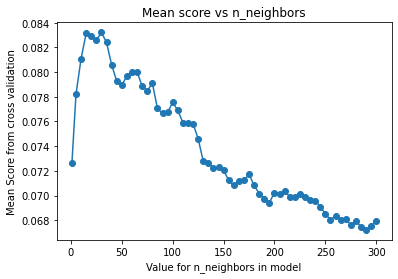

In [15]:
from sklearn.model_selection import GridSearchCV
plt.rcParams['figure.figsize'] = [15, 10]
# A function that takes in a K-NN model and values of k to test and displays graph representing the results
def graphk(knn_model, test_k, folds = 10):
    params=[{
        'n_neighbors': test_k,
    }]
    gs_knn = GridSearchCV(knn_model, param_grid=params, cv=folds, n_jobs=-1)
    gs_knn.fit(x_train, y_train)
    result_k = gs_knn.cv_results_['mean_test_score'].tolist()

    fig, ax = plt.subplots()
    ax.plot(test_k, result_k, '-o')
    ax.set_xlabel("Value for n_neighbors in model")
    ax.set_ylabel("Mean Score from cross validation")
    ax.set_title("Mean score vs n_neighbors")
    fig.show()

    return result_k

knn_model = KNeighborsClassifier(weights='distance')
test_k = [1] + [i for i in range(5,300+1,5)]
result_k = graphk(knn_model, test_k)

Based of the results of this graph, we can see that accuracy seems to peak around a specific number of neighbors, so we are making a new graph with values of k at intervals of 1 to find a optimal hyperparameter.

/tmp/ipykernel_123109/3475965497.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


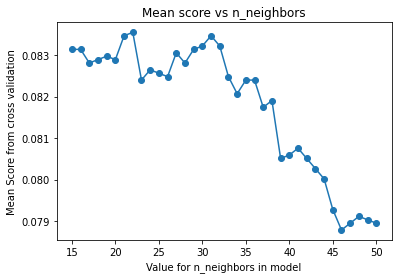

In [16]:
test_k = range(15,50+1)
result_k = graphk(knn_model, test_k)

From this graph we can grab the optimal k value.

In [17]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = test_k[index_of_max]
optimal_k_val

22

With all our hyper parameters picked out, we can train our final model and test it on our test set.

In [18]:
knn_model = KNeighborsClassifier(weights='distance', n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.08846722523410547

This suggests our model has an accuracy of 8%. 

In [19]:
len(y_test.unique())

471

For 471 candidates, a 8% accuracy in predicting candidates seems substantially better than random chance. To quantify just how much better, we are using McNemar's test to compare our model to random guessing.

In [71]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

def pvalue_against_random(model, x_train, y_train, x_test, y_test):
    dummy_classifier = DummyClassifier(strategy='uniform', random_state=41968)
    dummy_classifier.fit(x_train, y_train)
    # dummy_score = dummy_classifier.score(x_test, y_test)

    true_knn_true_dummy, true_knn_false_dummy, false_knn_true_dummy, false_knn_false_dummy = 0,0,0,0

    for i,true_val in enumerate(y_test):
        if model.predict(x_test[i:i+1]) == true_val:
            if dummy_classifier.predict(x_test[i:i+1]) == true_val:
                true_knn_true_dummy += 1
            else:
                true_knn_false_dummy += 1
        else:
            if dummy_classifier.predict(x_test[i:i+1]) == true_val:
                false_knn_true_dummy += 1
            else:
                false_knn_false_dummy += 1

    table = [[true_knn_true_dummy, true_knn_false_dummy], [false_knn_true_dummy, false_knn_false_dummy]]
    result = mcnemar(table, exact=True)
    return result.pvalue
    
pvalue_against_random(knn_model, x_train, y_train, x_test, y_test)

3.4654513001441956e-06

Based on the p-value, there is a 0.010% chance that we would have gotten the results we did if the null hypothesis was true. This is well below the 5% needed for significance in this class so we confidently reject the null hypothesis and claim `a candidate's spending in a particular quarter is related to their spending in other quarters`.

### K-NN Model to Predict a Candidate's Political Party
We would like test if the spending of a candidate is related to their political party. Our null hypothesis is that `a candidate's spending has no relation to their political party`. To test this hypothesis, we aim to train a K-NN model and test its mean accuracy. If the model performs significantly better than random chance, we will have good reason to reject the null hypothesis.

#### Model Specific Pre-processing
Our previous model leads us to believe that a candidates spending over the quarters are related. Since we aim to see if a candidates spending is related to their political party, it makes sense to average the data for each quarter for each candidate. This will prevent the model from predicting the party by simply predicting the candidate the data belongs to.

In [21]:
spending_member_info_combined = spending_member_info.groupby("BIOGUIDE_ID").mean()
# non numerical data does not get returned by mean() so we do a left join with the member table to get back the missing data
spending_member_info_combined = spending_member_info_combined.merge(members, on="BIOGUIDE_ID")
spending_member_info_combined

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE
0,A000014,-0.452057,-1.114295,-0.928102,-0.444181,-0.460533,-0.752098,-0.246321,-0.626004,-0.001998,-0.044306,-0.137986,-0.573328,0.0,ABERCROMBIE,NEIL,Democratic,Hawaii
1,A000022,-0.133267,-0.616120,-0.911492,0.750298,-0.315118,-0.291766,-0.139671,-0.616728,-0.001998,0.544612,-0.137986,-0.573328,0.0,ACKERMAN,GARY,Democratic,New York
2,A000055,-0.337505,0.199031,0.739885,-0.081758,-0.338762,-0.155582,-0.046018,0.092306,-0.001998,-0.044306,0.027771,-0.003087,0.0,ADERHOLT,ROBERT,Republican,Alabama
3,A000148,-0.464838,0.512343,-0.421681,-0.988880,-0.250063,-0.052488,-0.063178,0.789305,-0.001998,-0.044306,-0.137986,1.465716,0.0,AUCHINCLOSS,JAKE,Democratic,Massachusetts
4,A000210,0.003968,-0.679565,-0.907984,0.788232,-0.228174,-0.232435,-0.203576,-0.613914,-0.001998,-0.044306,-0.137986,-0.573328,0.0,ANDREWS,ROBERT,Democratic,New Jersey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,Y000064,0.099143,-0.547224,-0.152337,0.136092,0.152939,-0.309755,-0.198664,-0.622082,-0.001998,-0.044306,0.070948,-0.571891,0.0,YOUNG,TODD,Republican,Indiana
929,Y000065,-0.232389,-0.025401,0.160332,-0.388447,-0.195744,0.045415,-0.088429,0.109089,-0.001998,-0.044306,0.002671,0.106380,0.0,YOHO,TED,Republican,Florida
930,Y000066,0.062103,-0.212397,0.246023,-0.307393,-0.128965,0.024763,-0.074765,-0.000623,-0.001998,-0.040663,0.136783,0.104161,0.0,YOUNG,DAVID,Republican,Iowa
931,Z000017,0.680207,0.591174,-0.046317,-0.478143,0.365630,0.564778,-0.037599,0.673625,-0.001998,1.015258,0.219523,0.737462,0.0,ZELDIN,LEE,Republican,New York


Before training the model, we need to ensure that each party in the dataset has an appropriate number of datapoints. After going through the dataset, we realized that parties that are not the Democratic or Republican parties don't have enough data. We will isolate just Democratic and Republican members to ensure we have enough data to train and test the model for every party.

In [22]:
spending_member_info_2_party = pd.concat([spending_member_info_combined[spending_member_info_combined["PARTY"] == 'Republican'], spending_member_info_combined[spending_member_info_combined["PARTY"] == 'Democratic']])
spending_member_info_2_party["PARTY"].unique()

array(['Republican', 'Democratic'], dtype=object)

We are splitting the dataset into a training set and a test set so we have we can evaluate the model's performance on data it has not seen before.

In [23]:
x_train, x_test, y_train, y_test = train_test_split(spending_member_info_2_party[categories], spending_member_info_2_party["PARTY"])

#### Selecting Hyperparameters
All models that we use to tune our hyperparameters will use 10-fold cross validation to keep the training set larger by negating the need for a validation set. 

The first hyperparameter we want to choose between is the weight parameter so we are training 2 models with default parameters for everything except for the weighting.

In [24]:
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.6818633540372672

In [25]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train, cv=10).mean()

0.6818633540372672

It looks like both weighting methods produce extremely similar accuracies. As a result, we will use the distance weighting method because the closer a point is to other points, the more closely related we would expect them to be.

The second parameter we want to tune is the number of neighbors the model is considering. To do this we are training models for intervals of 5 between 5 and 300 to see where the accuracy of the model peak or starts having diminishing returns.

/tmp/ipykernel_123109/3475965497.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


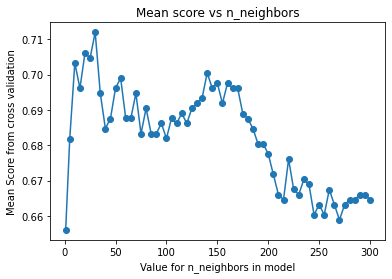

In [26]:
knn_model = KNeighborsClassifier(weights='distance')
test_k = [1] + [i for i in range(5,300+1,5)]
result_k = graphk(knn_model, test_k)

From the graph it seems like the ideal number of neighbors is in the range between 10 and 50. We can do a grid search of all values in that range to better visualize the space.

/tmp/ipykernel_123109/3475965497.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


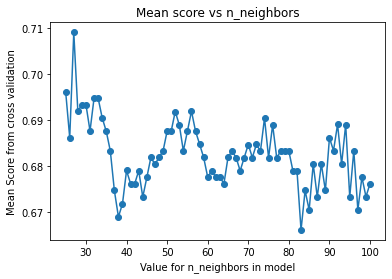

In [27]:
knn_model = KNeighborsClassifier()
test_k = range(25,100+1)
result_k = graphk(knn_model, test_k)

From this graph we can grab the optimal k value.

In [28]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = test_k[index_of_max]
optimal_k_val

27

With all our hyper parameters finalized, we can train our final model and test it on our test set.

In [29]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.7296137339055794

To measure if our model is doing significantly better than random chance, we are using McNemar's test to compare our model to random guessing.

In [30]:
pvalue_against_random(knn_model, x_train, y_train, x_test, y_test)

0.0007171910479201684

Based on the p-value, there is a 0.022% chance that we would have gotten the results we did if the null hypothesis was true. This is well below the 5% needed for significance in this class so we confidently reject the null hypothesis and claim `a candidate's spending is related to their political party`.

### K-NN Model to Predict the State a Candidate Represents
We would like test if the spending of a candidate is related to the state they represent. Our null hypothesis is that `a candidate's spending has no relation to the state they represent`. To test this hypothesis, we aim to train a K-NN model and test its mean accuracy. If the model performs significantly better than random chance, we will have good reason to reject the null hypothesis.

#### Model Specific Pre-processing
Our previous model leads us to believe that a candidates spending over the quarters are related. Since we aim to see if a candidates spending is related to their state, it makes sense to average the data for each quarter for each candidate. This will prevent the model from predicting the state by simply predicting the candidate the data belongs to. We already constructed this dataset in the previous model.

Before training the model, we need to ensure that each state in the dataset has an appropriate number of datapoints. After going through the dataset, decided to only include states that had atleast 9 datapoints. This would ensure that every fold of the testset would have atleast 1 datapoint.

In [31]:
spending_member_info_states_arr = []
for bio_id in spending_member_info_combined["STATE"].unique():
    count = sum(sum([spending_member_info_combined["STATE"] == bio_id]))
    if count >= 9:
        spending_member_info_states_arr.append(spending_member_info_combined[spending_member_info_combined["STATE"] == bio_id])
spending_member_info_states = pd.concat(spending_member_info_states_arr)
(len(spending_member_info_states["STATE"].unique()),len(spending_member_info_combined["STATE"].unique()))

(33, 56)

We are splitting the dataset into a training set and a test set so we have we can evaluate the model's performance on data it has not seen before.

In [32]:
x_train, x_test, y_train, y_test = train_test_split(spending_member_info_states[categories],spending_member_info_states["STATE"])

#### Selecting Hyperparameters
All models that we use to tune our hyperparameters will use 5-fold cross validation to keep the training set larger by negating the need for a validation set. 

The first hyperparameter we want to choose between is the weight parameter so we are training 2 models with default parameters for everything except for the weighting.

In [33]:
knn_model = KNeighborsClassifier()
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train).mean()

0.09960004999375079

In [34]:
knn_model = KNeighborsClassifier(weights='distance')
knn_trained = knn_model.fit(x_train, y_train)
cross_val_score(knn_trained, x_train, y_train).mean()

0.10752405949256343

It looks like the distance method is slightly better in terms of mean accuracy. This makes sense as we expect the closer a point is to other points, the more closely related we would expect them to be. Thus we will be using the distance weight method for this model.

The second parameter we want to tune is the number of neighbors the model is considering. To do this we are training models for intervals of 5 between 5 and 300 to see where the accuracy of the model peak or starts having diminishing returns.

/tmp/ipykernel_123109/3475965497.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


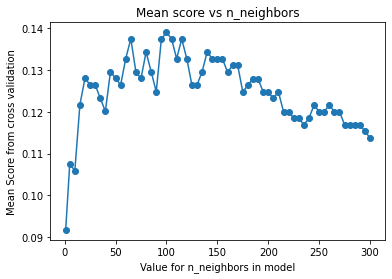

In [35]:
knn_model = KNeighborsClassifier(weights='distance')
test_k = [1] + [i for i in range(5,300+1,5)]
result_k = graphk(knn_model, test_k, folds = 5)

From the graph it seems like the ideal number of neighbors is in the range between 25 and 75. We can do a grid search of all values in that range to better visualize the space.

/tmp/ipykernel_123109/3475965497.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


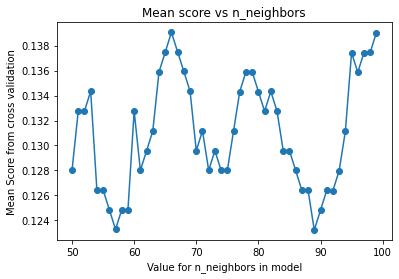

In [36]:
knn_model = KNeighborsClassifier(weights='distance')
test_k = range(50,100)
result_k = graphk(knn_model, test_k, folds = 5)

From this graph we can grab the optimal k value.

In [37]:
max_score = max(result_k)
index_of_max = result_k.index(max_score)
optimal_k_val = test_k[index_of_max]
optimal_k_val

66

With all our hyper parameters finalized, we can train our final model and test it on our test set.

In [38]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k_val)
knn_trained = knn_model.fit(x_train, y_train)
knn_model.score(x_test,y_test)

0.14691943127962084

To measure if our model is doing significantly better than random chance, we are using McNemar's test to compare our model to random guessing.

In [39]:
pvalue_against_random(knn_model, x_train, y_train, x_test, y_test)

3.4654513001441956e-06

Based on the p-value, there is a 0.026% chance that we would have gotten the results we did if the null hypothesis was true. This is well below the 5% needed for significance in this class so we confidently reject the null hypothesis and claim `a candidate's spending is related to the state they represent`.

# Part 3
## Cohorts of House members and personnel spending

For this part of the project, let's consider each freshman class of members of the House. To do this, we'll have to add in data from the elections dataframe as well. Note that we are using the date of each member's last election to the house and subtracting the number of terms they have served (per the data obtained from theunitedstates.io), since we are ignoring special elections (instead, we consider specially elected members as members of the previous cohort). 

In [40]:
import re
candidate_election_res = []
spending_election_df = spending_member_info_2_party.merge(us_io_data, on="BIOGUIDE_ID")
for index, row in spending_election_df.iterrows():
    candidate_res = (election_data[election_data['candidate'].str.contains(row['LASTNAME'], flags=re.IGNORECASE) & election_data['state'].str.contains(row['STATE'], flags=re.IGNORECASE)])
    if not candidate_res.empty:
        spending_election_df.loc[index, 'FIRST_ELECTED'] = candidate_res['year'].max() - int((row['TERMS'] - 1) * 2)

spending_election_df.dropna(subset=['FIRST_ELECTED'], inplace=True)

spending_election_df = spending_election_df[spending_election_df['FIRST_ELECTED'] >= 2010]
spending_election_df

,BIOGUIDE_ID,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE,TERMS,FIRST_ELECTED
4,A000366,0.234692,-0.817231,-0.843676,-0.223352,0.292859,-0.343963,-0.196878,-0.618497,-0.001998,-0.044306,-0.137986,-0.573328,0.0,ADAMS,SANDY,Republican,Florida,1,2010.0
5,A000369,-0.336037,0.062019,0.661364,0.072506,-0.294378,0.133079,0.061711,0.075094,-0.001998,-0.044306,0.088812,0.244605,0.0,AMODEI,MARK,Republican,Nevada,6,2010.0
6,A000372,0.949696,0.510046,0.525040,-0.629914,0.742248,0.293987,-0.142678,0.678539,-0.001998,-0.029724,0.046645,0.370382,0.0,ALLEN,RICK,Republican,Georgia,4,2014.0
7,A000374,-0.180673,0.364065,1.952370,-0.566415,-0.268948,-0.213693,-0.069666,0.424569,-0.001998,-0.028014,0.112540,0.203624,0.0,ABRAHAM,RALPH,Republican,Louisiana,3,2014.0
8,A000375,0.572672,0.625410,1.258931,-0.988880,0.524542,0.558004,0.025960,1.072245,-0.001998,-0.044306,-0.137986,0.957624,0.0,ARRINGTON,JODEY,Republican,Texas,3,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,W000801,-0.332981,-0.891262,-0.711312,-0.247890,-0.344026,-0.840481,-0.243016,-0.619933,-0.001998,-0.044306,-0.137986,-0.573328,0.0,WILSON,CHARLES,Democratic,Ohio,2,2010.0
926,W000808,-0.234206,0.192108,0.527052,0.006725,0.055721,-0.070790,-0.052058,0.178490,-0.001998,-0.044306,0.082500,0.275438,0.0,WILSON,FREDERICA,Democratic,Florida,6,2010.0
927,W000822,-0.193156,0.747329,-0.383242,-0.537876,-0.197430,0.589625,-0.007008,0.673334,-0.001998,0.033759,0.149885,0.526258,0.0,WATSON COLEMAN,BONNIE,Democratic,New Jersey,4,2014.0
928,W000825,0.525750,1.658705,-0.868002,-0.988880,0.644439,1.242952,0.023055,1.673530,-0.001998,-0.044306,-0.137986,1.028623,0.0,WEXTON,JENNIFER,Democratic,Virginia,2,2018.0


Here we have the spending dataframe from before, but now with the election data added. The "FIRST_ELECTED" column contains the election in which each member of the House was first elected. Since we are only concerned with evaluating the spending patterns of new cohorts of members of Congress, we need to have spending data for their entire congressional tenure - meaning that we need to drop any rows where "FIRST_ELECTED" is NaN (since these people were elected before 2010 and not subsequently re-elected), and any members whose first term started before 2010. 

As an example of this, we can generate violin plots of each cohort's spending on different categories. For example, we'll plot personnel compensation and travel. 

Text(0.5, 1.0, 'Cohorts of freshmen members of congress and their spending on personnel compensation')

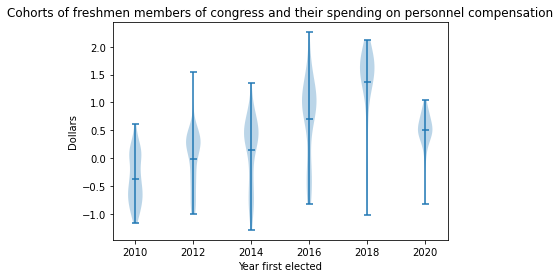

In [41]:
fig, ax = plt.subplots()
spending_cohort = []
for year in spending_election_df.FIRST_ELECTED.unique():
    spending_cohort.append(spending_election_df[spending_election_df.FIRST_ELECTED.eq(year)]['PERSONNEL COMPENSATION'])

ax.violinplot(spending_cohort, spending_election_df['FIRST_ELECTED'].unique(), showmeans=True)
ax.set_xlabel("Year first elected")
ax.set_ylabel("Dollars")
ax.set_title("Cohorts of freshmen members of congress and their spending on personnel compensation")

Text(0.5, 1.0, 'Cohorts of freshmen members of congress and their spending on travel')

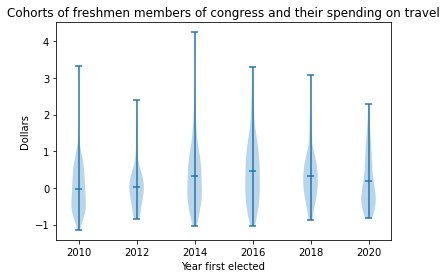

In [42]:
fig, ax = plt.subplots()
spending_cohort = []
for year in spending_election_df.FIRST_ELECTED.unique():
    spending_cohort.append(spending_election_df[spending_election_df.FIRST_ELECTED.eq(year)]['TRAVEL'])

ax.violinplot(spending_cohort, spending_election_df['FIRST_ELECTED'].unique(), showmeans=True)
ax.set_xlabel("Year first elected")
ax.set_ylabel("Dollars")
ax.set_title("Cohorts of freshmen members of congress and their spending on travel")

We can see that personnel compensation was much higher for members of congress initially elected in 2018. From here, we can suggest our null hypothesis (the default condition): that there is no correlation between the year a member of the House was initially elected and the amount they paid their staff. 

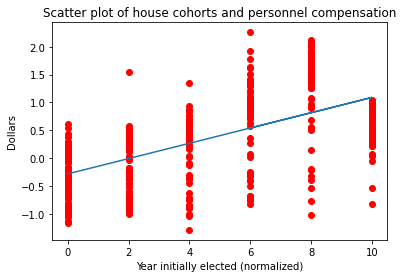

In [43]:
spending_election_df['NORMALIZED_COHORT'] = spending_election_df['FIRST_ELECTED'] - 2010
plt.plot(spending_election_df['NORMALIZED_COHORT'], spending_election_df['PERSONNEL COMPENSATION'], 'ro')
plt.title("Scatter plot of house cohorts and personnel compensation")
plt.xlabel("Year initially elected (normalized)")
plt.ylabel("Dollars")
(m, b) = np.polyfit(spending_election_df['NORMALIZED_COHORT'].values, spending_election_df['PERSONNEL COMPENSATION'].values, 1)
plt.plot(spending_election_df['NORMALIZED_COHORT'].values, b + m * spending_election_df['NORMALIZED_COHORT'].values, '-')
plt.show()

In [44]:
import statsmodels.formula.api as smf
spending_election_df.rename(columns={ 'PERSONNEL COMPENSATION': 'PERSONNEL_COMPENSATION'}, inplace=True)
mod = smf.ols(formula='PERSONNEL_COMPENSATION ~ NORMALIZED_COHORT', data=spending_election_df)

fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values)

Intercept            1.719108e-08
NORMALIZED_COHORT    1.424967e-47
Name: P>|t|, dtype: float64


After running our P-test, we can see that there is a statistical correlation between the cohort (in this case its normalized form), and the amount that each member of the house spent on paying their legislative staff. We can therefore reject the null hypothesis and conclude that there is a statistically significant correlation between freshman class and the amount spent on each member's office staff. 

# Part 4 - Predicting Election Results


It's possible that there is some sort of relation between spending and election success. While we likely can't draw any conculsion about causation, we can see if there is any way to have significantly better accuracy when trying to predict election results compared to random guessing. 

Before we can make a predictor, we will need to have a column for each type of expenditure. Earlier we found that there are 13 different spending categories. First we will sum up each category of expense, grouping by YEAR and BUIOGUIDE_ID.

In [45]:
years = house_data['YEAR'].unique()

# get lists of all the unique categories and bioguide ids
categories = house_data['CATEGORY'].unique()
bio_ids = house_data['BIOGUIDE_ID'].unique()

year = years[0]


# get the total spending on each categeory per representative per year
spending_per_candidate = house_data.groupby(['YEAR', 'BIOGUIDE_ID','CATEGORY'])['AMOUNT'].sum()

spending_data = []
# for each year and representative, add the spending for each category into a column and add that row to the spending_data list
for year in years:
    for bio_id in bio_ids:
        # set the row to be the bio_id and year
        if bio_id in spending_per_candidate[year]:
            row = [bio_id, year]
            for category in categories:
                if category in spending_per_candidate[year][bio_id]:
                    row.append(spending_per_candidate[year][bio_id][category])
                else:
                    row.append(np.nan)
            spending_data.append(row)

# create a dataframe from the spending_data list
year_spending_df = pd.DataFrame(spending_data,columns = ["BIOGUIDE_ID", "YEAR"] + categories.tolist())

# replace the NaNs with 0
year_spending_df.fillna(0, inplace=True)
year_spending_df

# combine totals for years into pairs of two

,BIOGUIDE_ID,YEAR,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL
0,A000014,2010,2266.98,399676.44,16006.37,40029.73,809.17,21790.94,8060.10,1561.64,0.0,0.0,0.0,0.00,0.0
1,A000022,2010,57369.91,809865.31,12088.22,94258.63,32823.68,47198.47,57789.15,3378.11,0.0,0.0,0.0,0.00,0.0
2,A000055,2010,6366.69,844798.48,59921.19,61797.60,10534.11,34825.20,35934.66,19814.71,0.0,0.0,0.0,0.00,0.0
3,A000364,2010,132494.41,560056.62,24049.16,80818.63,145486.95,52175.64,16258.35,11966.76,0.0,0.0,0.0,0.00,0.0
4,A000358,2010,47826.63,804843.19,20078.96,66744.24,46618.69,38674.55,26022.08,6967.16,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5646,V000134,2020,-5.86,1353211.74,86311.60,0.00,18031.14,54530.00,83260.86,1835097.82,0.0,0.0,0.0,219538.94,0.0
5647,W000788,2020,53590.98,1167107.72,31895.40,0.00,112248.86,59045.78,50875.06,1600462.26,0.0,0.0,0.0,155816.58,0.0
5648,C001125,2020,0.00,534546.28,17325.02,0.00,10285.20,13214.00,190881.04,483877.74,0.0,0.0,0.0,69925.12,0.0
5649,S001218,2020,-136.00,548963.32,34436.78,0.00,4928.36,9490.72,8175.24,615027.56,0.0,0.0,0.0,12471.30,0.0


Since house elections only happen every 2 years, we will sum up adjacent years prior to an election for the sake of this regression. For example, the data for 2017 and 2018 will be added and categorized as 2018 since those are the years after the 2016 election but (mostly) before the 2018 elections.

Once this is done we also want to normalize each of the columns so that we are just looking at how spending within columns compares between candidates.

In [46]:
parts = []

def helper(x):
    years = house_data['YEAR'].unique()
    # add together the first two years  
    if years[0] % 2 == 1:
        start = 0
    else:
        start = 1
    if years[-1] % 2 == 1:
        end = len(years) - 1
    else:
        end = len(years)

    #add together the first 2 columns of x
    for i in range(start, end, 2):
        # sum together the money amoutns for the two years
        row = x[i:i+2].sum()

        #fix bioguide id and year since those also got summed
        row['YEAR'] = int(years[i+1])
        row['BIOGUIDE_ID'] = x[0:1]["BIOGUIDE_ID"].values[0]

        # add together all the other columns and then change values to proportions
        
        sum = 0
        for category in categories:
            sum += row[category]

        # now calculate the proportions
        success = True
        for category in categories:
            if sum == 0:
                #row[category] = row[category] / sum
                success = False
        
        # if the sum is 0, then they weren't in office for the years so they shouldn't be included
        if success:
            parts.append(row)
        
        # Now check whether or not they won the election for that year
            
year_spending_df.groupby('BIOGUIDE_ID').apply(helper)
merged_years_df = pd.DataFrame(parts)

# get the mean and std of each column
mean = merged_years_df.mean()
std = merged_years_df.std()

def normalize(df):
    for category in categories:
        df[category] = (df[category] - mean[category]) / std[category]
    return df
merged_years_df = merged_years_df.apply(normalize, axis=1)


# add party and name info
merged_years_df = merged_years_df.merge(members, on='BIOGUIDE_ID')
# replace the NaNs with 0
merged_years_df.fillna(0, inplace=True)
merged_years_df

/tmp/ipykernel_123109/1742205919.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = merged_years_df.mean()
/tmp/ipykernel_123109/1742205919.py:48: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = merged_years_df.std()
/tmp/ipykernel_123109/1742205919.py:52: RuntimeWarning: invalid value encountered in double_scalars
  df[category] = (df[category] - mean[category]) / std[category]


,BIOGUIDE_ID,YEAR,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE
0,A000014,2012,-0.768845,-1.559867,-1.204825,-0.888595,-0.750781,-1.472036,-0.362717,-0.742109,0.00669,-0.108390,-0.417400,-0.692100,0.0,ABERCROMBIE,NEIL,Democratic,Hawaii
1,A000022,2012,-0.110199,-0.147643,-0.855931,1.913155,-0.501801,0.149710,-0.143398,-0.719475,0.00669,-0.108390,-0.417400,-0.692100,0.0,ACKERMAN,GARY,Democratic,New York
2,A000022,2014,-0.768563,-1.556740,-1.132882,-0.870655,-0.715338,-1.393939,-0.359629,-0.741504,0.00669,3.172186,-0.417400,-0.692100,0.0,ACKERMAN,GARY,Democratic,New York
3,A000055,2012,-0.587788,-0.223364,0.333803,0.651693,-0.580720,0.339710,-0.210199,-0.710266,0.00669,-0.108390,-0.417400,-0.692100,0.0,ADERHOLT,ROBERT,Republican,Alabama
4,A000055,2014,-0.585794,-0.273172,0.243283,0.815674,-0.610137,-0.206924,-0.142614,-0.718898,0.00669,-0.108390,-0.417400,-0.692100,0.0,ADERHOLT,ROBERT,Republican,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,Z000017,2012,0.755272,0.254871,-0.191964,-0.112434,0.228914,0.224543,-0.249117,0.073670,0.00669,7.865984,2.846163,0.258573,0.0,ZELDIN,LEE,Republican,New York
2590,Z000017,2014,1.848051,1.163734,0.569423,-0.888595,1.124020,1.765201,0.150353,1.501474,0.00669,0.402030,-0.417400,1.448452,0.0,ZELDIN,LEE,Republican,New York
2591,Z000017,2016,1.487613,0.916972,-0.182616,-0.888595,0.941298,0.902035,0.009142,1.286651,0.00669,-0.108390,-0.417400,1.359694,0.0,ZELDIN,LEE,Republican,New York
2592,Z000018,2012,-0.049084,-0.588931,0.548517,-0.337278,-0.090897,-0.552062,0.471959,-0.709329,0.00669,-0.108390,1.996647,-0.423496,0.0,ZINKE,RYAN,Republican,Montana


Now we need to add a column to represent whether they won or lost in that election year. If they didn't run for reelection that year, it will be NaN. Rows with NaN for the election result will be dropped since they didn't run in the election that year, meaning they aren't relevant to the correlation we are looking into. Some states like NY have the same candidate multiple times under different parties so we also need to handle summing up those counts.

In [47]:
merged_years_df['WIN'] = [0 for i in range(len(merged_years_df))]

def add_victory(row):
    # look up the row in the election data
    thing = election_data.loc[(election_data['last_name'] == row['LASTNAME']) & (election_data['year'] == row['YEAR']) & (election_data['first_name'] == row['FIRSTNAME'])]
    # set win column to 1 if they won
    if len(thing) == 1:
        if thing['totalvotes'].values[0] == 0:
            row['WIN'] = np.nan
        elif float(thing['candidatevotes'].values[0]) / float(thing['totalvotes'].values[0]) >= 0.5:
            row['WIN'] = 1
    elif len(thing) > 1:
        #in some places like NY, you can run in the same race under multiple parties, so we need to add these votes together for our calculation
        total_votes = 0
        for votes in thing['candidatevotes'].values:
            total_votes += votes
        
        if thing['totalvotes'].values[0] == 0:
            row['WIN'] = np.nan
        elif total_votes / float(thing['totalvotes'].values[0]) >= 0.5:
            row['WIN'] = 1
            
    else:
        row['WIN'] = np.nan
    
    return row

victory_df = merged_years_df.apply(add_victory, axis = 1)

#finally drop the rows with NaN in the win column
victory_df.dropna(subset = ['WIN'], inplace=True)
victory_df

,BIOGUIDE_ID,YEAR,FRANKED MAIL,PERSONNEL COMPENSATION,TRAVEL,"RENT, COMMUNICATION, UTILITIES",PRINTING AND REPRODUCTION,OTHER SERVICES,SUPPLIES AND MATERIALS,EQUIPMENT,PERSONNEL BENEFITS,TRANSPORTATION OF THINGS,RENT COMMUNICATION UTILITIES,RENT COMMUNICATION UTILITIES,BENEFITS TO FORMER PERSONNEL,LASTNAME,FIRSTNAME,PARTY,STATE,WIN
3,A000055,2012,-0.587788,-0.223364,0.333803,0.651693,-0.580720,0.339710,-0.210199,-0.710266,0.00669,-0.10839,-0.417400,-0.692100,0.0,ADERHOLT,ROBERT,Republican,Alabama,1.0
4,A000055,2014,-0.585794,-0.273172,0.243283,0.815674,-0.610137,-0.206924,-0.142614,-0.718898,0.00669,-0.10839,-0.417400,-0.692100,0.0,ADERHOLT,ROBERT,Republican,Alabama,1.0
5,A000055,2016,-0.583601,-0.294345,0.422442,0.724491,-0.597988,-0.671032,-0.148299,-0.714367,0.00669,-0.10839,2.230581,-0.692100,0.0,ADERHOLT,ROBERT,Republican,Alabama,1.0
6,A000055,2018,-0.437503,0.629688,2.028267,-0.888595,-0.529857,-0.396709,-0.147613,0.877106,0.00669,-0.10839,-0.417400,0.824287,0.0,ADERHOLT,ROBERT,Republican,Alabama,1.0
7,A000055,2020,-0.282139,2.565609,2.621952,-0.888595,-0.180810,0.879658,0.497393,2.473009,0.00669,-0.10839,-0.417400,1.706963,0.0,ADERHOLT,ROBERT,Republican,Alabama,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586,Y000065,2018,-0.754706,-0.151157,-0.801241,-0.888595,-0.646034,-0.254098,-0.156058,0.302156,0.00669,-0.10839,-0.417400,0.117283,0.0,YOHO,TED,Republican,Florida,1.0
2588,Y000066,2014,-0.043353,-0.179364,0.322002,-0.888595,-0.359450,-0.072724,-0.031826,0.376609,0.00669,-0.10839,-0.417400,0.392202,0.0,YOUNG,DAVID,Republican,Iowa,1.0
2590,Z000017,2014,1.848051,1.163734,0.569423,-0.888595,1.124020,1.765201,0.150353,1.501474,0.00669,0.40203,-0.417400,1.448452,0.0,ZELDIN,LEE,Republican,New York,1.0
2591,Z000017,2016,1.487613,0.916972,-0.182616,-0.888595,0.941298,0.902035,0.009142,1.286651,0.00669,-0.10839,-0.417400,1.359694,0.0,ZELDIN,LEE,Republican,New York,1.0


We can make violin plots of each of the categoreis to see how spending in each of the categories is distributed. We can see if there's any obvious skew or a different number of peaks for a specific category.

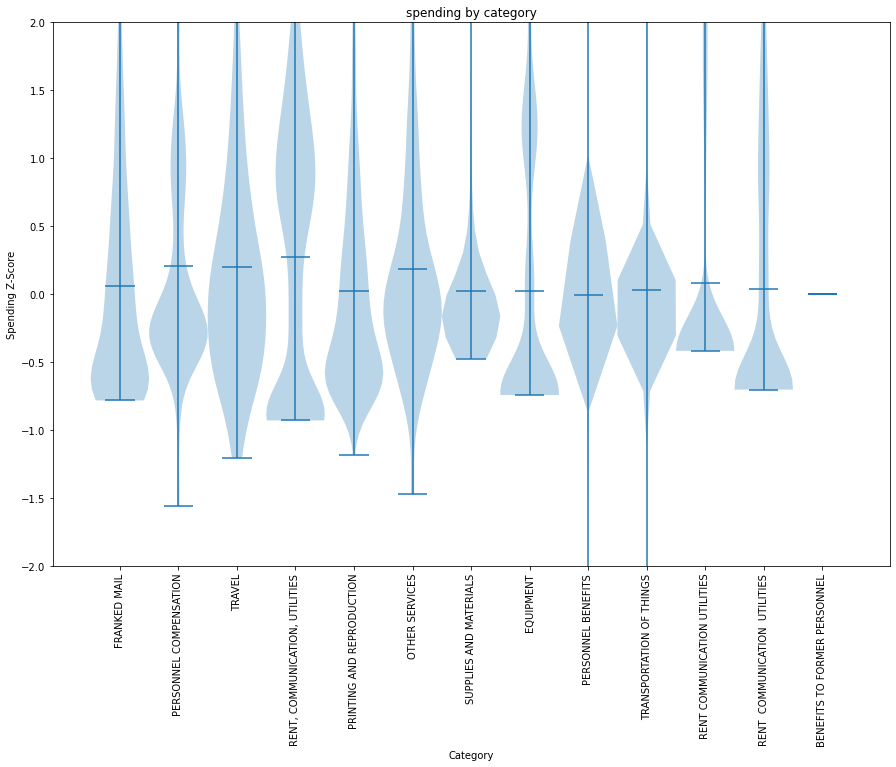

In [102]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# make an array of all the categories we want to plot
category_data = []
for category in categories:
    # get the data for the category
    category_data.append(victory_df[category].values)

#print (category_data)

ax.violinplot(category_data,range(len(categories)),widths=1,showmeans=True)
ax.set_xlabel("Category")
ax.set_ylabel("Spending Z-Score")
ax.set_title("spending by category")
plt. ylim(-2, 2)

plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
ax.xaxis.set_ticks(range(len(categories)))  # Set the X-Axis Ticks
ax.set_xticklabels(categories);

It's possible that different parties will spend their money in different ways, so let's take a look at violin plots split by party as well.

4


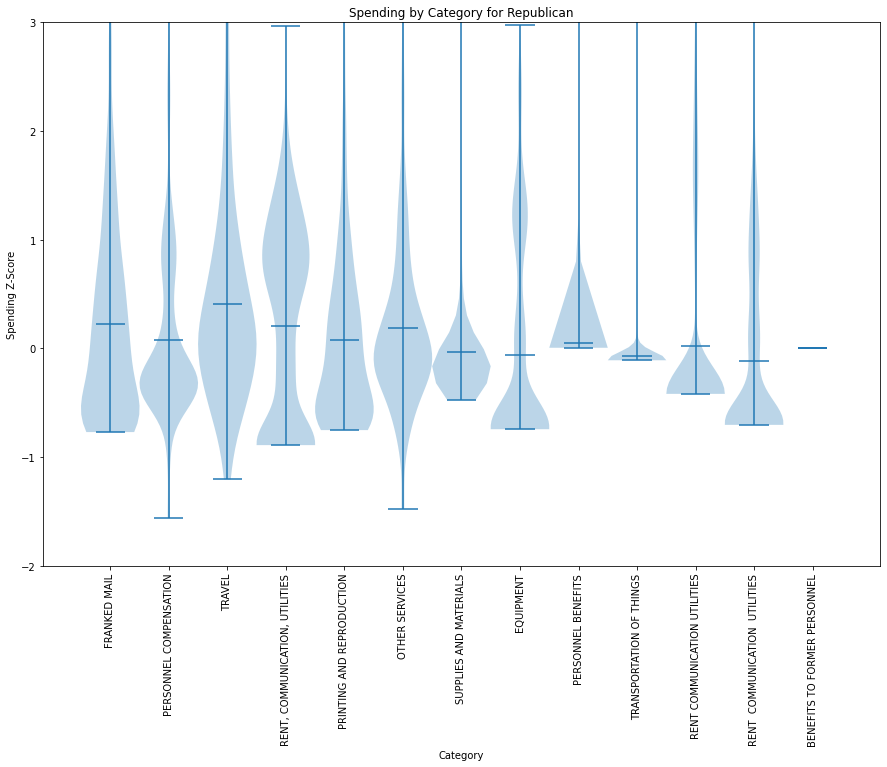

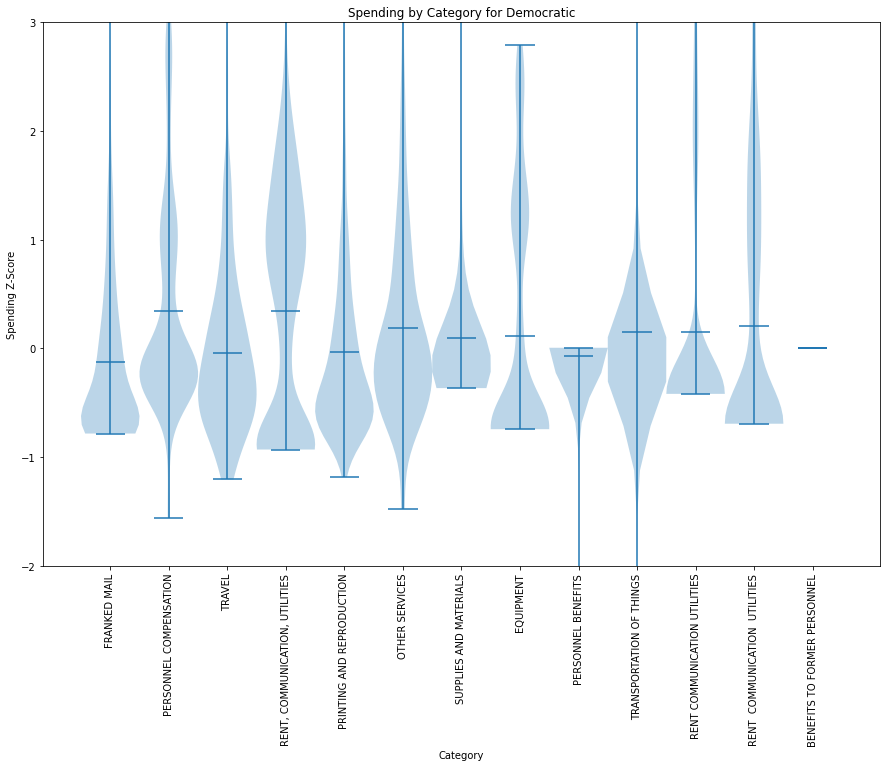

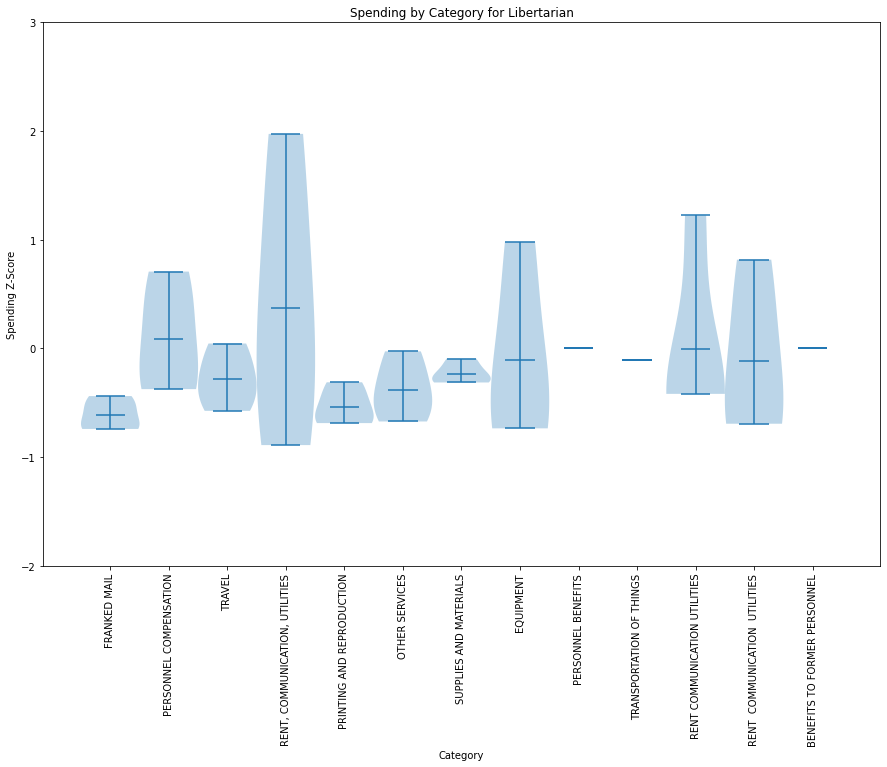

In [100]:
party_dfs = []

# split into two dfs for parties
for party in victory_df['PARTY'].unique():
    party_dfs.append(victory_df[victory_df['PARTY'] == party])
# victory_df.groupby('PARTY').apply(lambda x: party_dfs.append(x))

# now graph violins for each!
# Code to change default plot size:
# make an array of all the categories we want to plot
for df in party_dfs:
    fig, ax = plt.subplots()
    
    
    category_data = []
    for category in categories:
        # get the data for the category
        category_data.append(df[category].values)

    #print (category_data)
    ax.violinplot(category_data,range(len(categories)),widths=1,showmeans=True)

    ax.set_xlabel("Category")
    ax.set_ylabel("Spending Z-Score")
    ax.set_title("Spending by Category for " + df['PARTY'].values[0])
    plt. ylim(-2, 3)
    fig.savefig("partiesViolin.png")

    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    ax.xaxis.set_ticks(range(len(categories)))  # Set the X-Axis Ticks
    ax.set_xticklabels(categories)

We can see based on this violin plot that for most categories there isn't a massive difference between the parties, but there is still a noticeable enough difference that it could be worth adding a party as an interaction variable. The Libertarian party only had 1 candidiate who was in office for 4 time periods which is why the third plot differs from the other two.

Now that the data has been setup with columns representing each expense category as well as election results, we can see if we can predict victory based on spending habits. To do this, we train a knn model on each specific category to see if individual categories correlation with election success. We also train a model using all of the columns together. To choose the k we want to use for knn, we use tenfold cross validation on the training data. Whichever k has the highest accuracy will be used to train the final model that we'll use on the test set. 

In [79]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as ms
import sklearn.metrics as met

# use PERSONAL_COMPENSATION for ind and WIN for dep
y = victory_df['WIN']
for category in categories:
    X = victory_df[[category]]
    ind_train, ind_test, dep_train, dep_test = ms.train_test_split(X, y, random_state=64)
    k_range = range(1, 10) # we will try k values from 1 to 10
    k_scores = []

    # train a model for each value of k and store the score in k_scores
    for k in k_range:
        neighbors = KNeighborsClassifier(n_neighbors=k)
        scores = ms.cross_val_score(neighbors, ind_train, dep_train, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())

    # get the value of k with the highest cross-validated precision
    k = k_scores.index(max(k_scores)) + 1

    #train the dataset with the hyperparameter we just found
    neighbors = KNeighborsClassifier(n_neighbors=k)
    neighbors.fit(ind_train, dep_train)

    predicted = neighbors.predict(ind_test)
    acc = met.accuracy_score(dep_test, predicted, normalize=True, sample_weight=None)
    print("Accuracy:", acc)

    actual = np.array(dep_test)
    predictions = np.array(predicted)
    print(category + '\n' + str(met.confusion_matrix(actual, predictions)))

# now try a model on all categories
# ignore the last column since it is the NaN expense column
X = victory_df[categories]
ind_train, ind_test, dep_train, dep_test = ms.train_test_split(X, y, random_state=64)
k_range = range(1, 10) # we will try k values from 1 to 10
k_scores = []
for k in k_range:
    neighbors = KNeighborsClassifier(n_neighbors=k)
    scores = ms.cross_val_score(neighbors, ind_train, dep_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

# get the value of k with the highest cross-validated accuracy
k = k_scores.index(max(k_scores)) + 1

#train the dataset with the hyperparameter we just found
neighbors = KNeighborsClassifier(n_neighbors=k)
neighbors.fit(ind_train, dep_train)

predicted = neighbors.predict(ind_test)
acc = met.accuracy_score(dep_test, predicted, normalize=True, sample_weight=None)
print("Accuracy:", acc)

actual = np.array(dep_test)
predictions = np.array(predicted)
print("All" + '\n' + str(met.confusion_matrix(actual, predictions)))


Accuracy: 0.9324675324675324
FRANKED MAIL
[[  0  25]
 [  1 359]]
Accuracy: 0.9376623376623376
PERSONNEL COMPENSATION
[[  4  21]
 [  3 357]]
Accuracy: 0.935064935064935
TRAVEL
[[  0  25]
 [  0 360]]
Accuracy: 0.9376623376623376
RENT, COMMUNICATION, UTILITIES
[[  2  23]
 [  1 359]]
Accuracy: 0.935064935064935
PRINTING AND REPRODUCTION
[[  0  25]
 [  0 360]]
Accuracy: 0.9298701298701298
OTHER SERVICES
[[  1  24]
 [  3 357]]
Accuracy: 0.9402597402597402
SUPPLIES AND MATERIALS
[[  3  22]
 [  1 359]]
Accuracy: 0.9246753246753247
EQUIPMENT
[[  3  22]
 [  7 353]]
Accuracy: 0.935064935064935
PERSONNEL BENEFITS
[[  0  25]
 [  0 360]]
Accuracy: 0.935064935064935
TRANSPORTATION OF THINGS
[[  0  25]
 [  0 360]]
Accuracy: 0.935064935064935
RENT COMMUNICATION UTILITIES
[[  0  25]
 [  0 360]]
Accuracy: 0.935064935064935
RENT  COMMUNICATION  UTILITIES
[[  0  25]
 [  0 360]]
Accuracy: 0.935064935064935
BENEFITS TO FORMER PERSONNEL
[[  0  25]
 [  0 360]]
Accuracy: 0.9428571428571428
All
[[  5  20]
 [  2 

We can see that using all columns has the highest precision, and it also has much less false negatives compared to most of the models using a single column. Our final model will be the model that uses all of the columns.

Now we can calculate the p-score using the same tactic described earlier.

In [80]:
pvalue_against_random(neighbors, ind_train, dep_train, ind_test, dep_test)

0.453125

It's clear from looking at these results that the data does seem to predict incumbency, but for some categories, it does predict some of the losses correctly. Could it be possible that the model could be more accurate if political party is also taken into account? We can make party into an interaction varible!

In [81]:
# add a new columns for Democrat and Republican onehot encoded
victory_df['Democrat'] = victory_df['PARTY'].apply(lambda x: 0 if x == 'Democratic' else 1)
victory_df['Republican'] = victory_df['PARTY'].apply(lambda x: 0 if x == 'Republican' else 1)

# Now let's redo the previous models but now with the party_num interaction variable
y = victory_df['WIN']

for category in categories:
    X = victory_df[[category, 'Democrat', 'Republican']]
    ind_train, ind_test, dep_train, dep_test = ms.train_test_split(X, y, random_state=64)

    k_range = range(1, 10) # we will try k values from 1 to 10
    k_scores = []
    for k in k_range:
        neighbors = KNeighborsClassifier(n_neighbors=k)
        scores = ms.cross_val_score(neighbors, ind_train, dep_train, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())

    # get the value of k with the highest cross-validated precision
    k = k_scores.index(max(k_scores)) + 1

    #train the dataset with the hyperparameter we just found
    neighbors = KNeighborsClassifier(n_neighbors=k)
    neighbors.fit(ind_train, dep_train)

    predicted = neighbors.predict(ind_test)
    acc = met.accuracy_score(dep_test, predicted, normalize=True, sample_weight=None)
    print("Accuracy:", acc)

    actual = np.array(dep_test)
    predictions = np.array(predicted)
    print(category + '\n' + str(met.confusion_matrix(actual, predictions)))

# now try a model on all categories
# ignore the last column since it is the NaN expense column
onehot_categories = list(categories)
onehot_categories.append('Democrat')
onehot_categories.append('Republican')
X = victory_df[onehot_categories]
ind_train, ind_test, dep_train, dep_test = ms.train_test_split(X, y, random_state=60)
k_range = range(1, 10) # we will try k values from 1 to 10
k_scores = []
for k in k_range:
    neighbors = KNeighborsClassifier(n_neighbors=k)
    scores = ms.cross_val_score(neighbors, ind_train, dep_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

# get the value of k with the highest cross-validated precision
k = k_scores.index(max(k_scores)) + 1

#train the dataset with the hyperparameter we just found
neighbors = KNeighborsClassifier(n_neighbors=k)
neighbors.fit(ind_train, dep_train)

predicted = neighbors.predict(ind_test)
acc = met.accuracy_score(dep_test, predicted, normalize=True, sample_weight=None)
print("Accuracy:", acc)

actual = np.array(dep_test)
predictions = np.array(predicted)
print("All" + '\n' + str(met.confusion_matrix(actual, predictions)))

Accuracy: 0.9324675324675324
FRANKED MAIL
[[  0  25]
 [  1 359]]
Accuracy: 0.9428571428571428
PERSONNEL COMPENSATION
[[  3  22]
 [  0 360]]
Accuracy: 0.9324675324675324
TRAVEL
[[  0  25]
 [  1 359]]
Accuracy: 0.935064935064935
RENT, COMMUNICATION, UTILITIES
[[  0  25]
 [  0 360]]
Accuracy: 0.935064935064935
PRINTING AND REPRODUCTION
[[  0  25]
 [  0 360]]
Accuracy: 0.9324675324675324
OTHER SERVICES
[[  0  25]
 [  1 359]]
Accuracy: 0.9298701298701298
SUPPLIES AND MATERIALS
[[  0  25]
 [  2 358]]
Accuracy: 0.9298701298701298
EQUIPMENT
[[  0  25]
 [  2 358]]
Accuracy: 0.935064935064935
PERSONNEL BENEFITS
[[  0  25]
 [  0 360]]
Accuracy: 0.935064935064935
TRANSPORTATION OF THINGS
[[  0  25]
 [  0 360]]
Accuracy: 0.935064935064935
RENT COMMUNICATION UTILITIES
[[  0  25]
 [  0 360]]
Accuracy: 0.935064935064935
RENT  COMMUNICATION  UTILITIES
[[  0  25]
 [  0 360]]
Accuracy: 0.935064935064935
BENEFITS TO FORMER PERSONNEL
[[  0  25]
 [  0 360]]
Accuracy: 0.9454545454545454
All
[[  7  15]
 [  6 

In [87]:
pvalue_against_random(neighbors, ind_train, dep_train, ind_test, dep_test)

1.0